In [441]:
import pandas as pd
from pathlib import Path

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import VarianceThreshold

from imblearn import over_sampling as ovs
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV,RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer

%matplotlib inline

In [410]:
sns.set_context(context="paper")


In [411]:
ABPRED_DIR = Path().cwd().parent
DATA = ABPRED_DIR / "data"

#dataframe final
df_final = pd.read_csv(DATA/"../data/DF_contact300_energy_2019.csv",index_col=0)
# Quitar modelos por homologia deltraining set
#df_final_onlyHM = df_final.loc[df_final.index.str.startswith("HM")]
#df_final= df_final.loc[~df_final.index.str.startswith("HM")]

index_ddg8 = (df_final['ddG_exp']==8)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG_exp'] <= -4)
df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


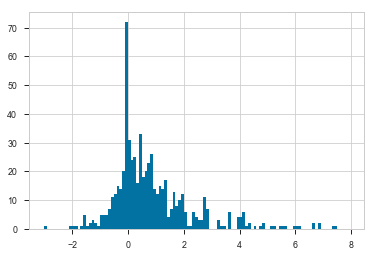

In [412]:
bini = np.arange(-3,8,0.1)
df_final['ddG_exp'].hist(bins=bini)

# models normal

In [413]:
X = df_final.drop('ddG_exp',axis=1)
y = df_final['ddG_exp']

In [415]:
# split for final test
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75,random_state=1212)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Linear, default

In [16]:
selector = VarianceThreshold()

#1) standarization
scaler = MinMaxScaler()
#scaler = StandardScaler()

#pca = PCA()
#2)
lr_model = LinearRegression()
#3) Crear pipeline
#pipeline1 = make_pipeline(scaler ,pca,lr_model)
pipeline1 = make_pipeline(selector,scaler ,lr_model)


# 5) hiperparametros a ajustar
param_grid = {"linearregression__fit_intercept":[True,False],"linearregression__normalize":[True,False]}

#param_grid = {"linearregression__fit_intercept":[True,False],"linearregression__normalize":[True,False],'pca__n_components':[10,20,30,40,50,60,70,80,90,100]}
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=10,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid1.fit(X_train, y_train)


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [17]:
grid1.best_score_

-92.30510768339529

In [18]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))

CV test RMSE 13.049792 +/- 21.294316
CV train RMSE 0.566451 +/- 0.147272
CV test r2 -92.305108 +/- 251.322408
CV train r2 0.853101 +/- 0.013577
{'linearregression__fit_intercept': True, 'linearregression__normalize': False}

RMSE for test dataset: 2.06
RMSE for train dataset: 0.64
pearson corr  0.311848


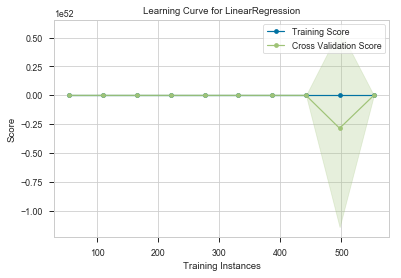

In [19]:
viz = LearningCurve(grid1.best_estimator_, n_jobs=-1,cv=10, scoring='r2',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X, y)
viz.poof()

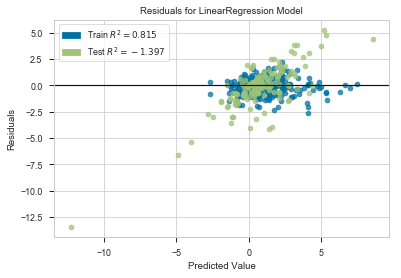

In [20]:
visualizer = ResidualsPlot(grid1.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


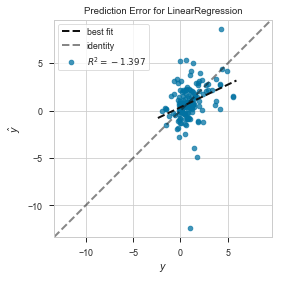

In [21]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

# l2 regularization or Ridge, default

In [22]:
np.arange(1,5,0.1)

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9])

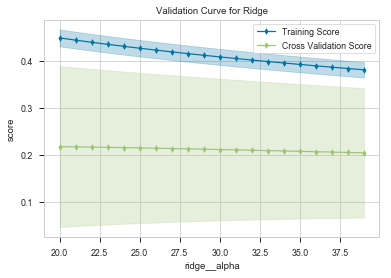

In [51]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

# Load a regression dataset

selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = Ridge()
#3) Crear pipeline
pipeline2 = make_pipeline(selector,scaler,lr_model)

# Extract the instances and target
viz = ValidationCurve(
    pipeline2, njobs=-1,param_name="ridge__alpha",
    param_range=np.arange(20,40,1), cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [64]:
selector = VarianceThreshold()
#1)
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = Ridge()
#3) Crear pipeline
pipeline2 = make_pipeline(selector,scaler,lr_model)

# 5) hiperparametros a ajustar
#param_grid = {"ridge__alpha":[0.1,1.0,10,100],"ridge__normalize":[True,False],"ridge__fit_intercept":[True,False],'pca__n_components':[10,20,30,40,50,60,70,80,90,100]}
param_grid = {"ridge__alpha":[40],"ridge__normalize":[True,False],"ridge__fit_intercept":[True,False]}

grid2 = GridSearchCV(pipeline2, param_grid, verbose=5, n_jobs=-1,cv=10,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
#grid2 = GridSearchCV(pipeline2, param_grid, verbose=5, n_jobs=-1,cv=10,scoring='r2',return_train_score=True)
# fit
grid2.fit(X_train, y_train)


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ridge__alpha': [40], 'ridge__normalize': [True, False], 'ridge__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [65]:
# index of best scores
rmse_bestCV_test_index = grid2.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid2.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid2.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid2.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid2.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid2.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid2.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid2.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid2.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid2.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid2.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid2.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(grid2.best_params_)
y_test_pred = grid2.best_estimator_.predict(X_test)
y_train_pred = grid2.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))

CV test RMSE 1.280571 +/- 0.763392
CV train RMSE 1.165820 +/- 0.198613
CV test r2 0.204957 +/- 0.136446
CV train r2 0.378936 +/- 0.016375
{'ridge__alpha': 40, 'ridge__fit_intercept': False, 'ridge__normalize': True}

RMSE for test dataset: 1.08
RMSE for train dataset: 1.17
pearson corr  0.616954


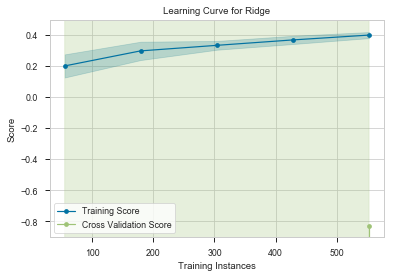

In [424]:

viz = LearningCurve(grid2.best_estimator_, n_jobs=-1,cv=10, scoring='r2')
viz.fit(X, y)
plt.ylim(-0.9,0.5)
viz.poof()

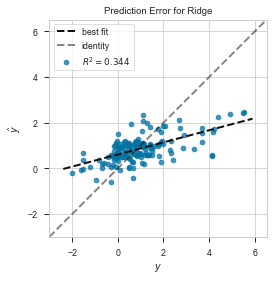

In [425]:
perror = PredictionError(grid2.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

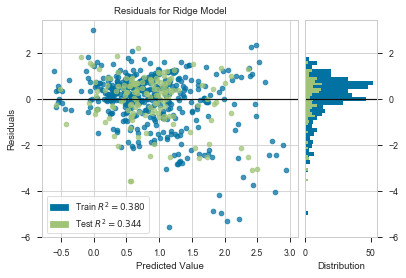

In [426]:
visualizer = ResidualsPlot(grid2.best_estimator_,hist=True)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


# l1 Regularization or Lasso Regression

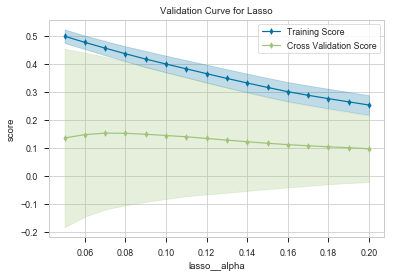

In [118]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve


selector = VarianceThreshold()
#scaler = MinMaxScaler()
scaler = StandardScaler()
#2)
lr_model = Lasso()
#3) Crear pipeline
pipeline3 = make_pipeline(selector,scaler,lr_model)

# Extract the instances and target
viz = ValidationCurve(
    pipeline3, njobs=-1,param_name="lasso__alpha",
    param_range=np.arange(0.05,0.2,0.01), cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [427]:
#1)
selector = VarianceThreshold()
#scaler = MinMaxScaler()
scaler = StandardScaler()
#2)
lr_model = Lasso()
#3) Crear pipeline
pipeline3 = make_pipeline(selector,scaler,lr_model)



# fit
pipeline3.fit(X_train,y_train)

# 5) hiperparametros a ajustar
#param_grid = {"lasso__alpha":[0.001, 0.1,1.0,10],"lasso__normalize":[True,False],"lasso__fit_intercept":[True,False],'pca__n_components':[10,20,30,40,50,60,70,80,90,100]}
param_grid = {"lasso__alpha":[0.07,0.08,0.09,0.01],"lasso__normalize":[True,False],"lasso__fit_intercept":[True,False]}

grid3 = GridSearchCV(pipeline3, param_grid, verbose=5, n_jobs=-1,cv=10,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid3.fit(X_train, y_train)


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.0s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lasso__alpha': [0.07, 0.08, 0.09, 0.01], 'lasso__normalize': [True, False], 'lasso__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [428]:
# index of best scores
rmse_bestCV_test_index = grid3.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid3.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid3.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid3.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid3.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid3.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid3.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid3.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid3.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid3.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid3.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid3.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(grid3.best_params_)
y_test_pred = grid3.best_estimator_.predict(X_test)
y_train_pred = grid3.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))

CV test RMSE 1.281320 +/- 0.634572
CV train RMSE 0.840899 +/- 0.209170
CV test r2 0.156110 +/- 0.267562
CV train r2 0.676456 +/- 0.026023
{'lasso__alpha': 0.07, 'lasso__fit_intercept': False, 'lasso__normalize': True}

RMSE for test dataset: 1.44
RMSE for train dataset: 1.39
pearson corr  0.611572


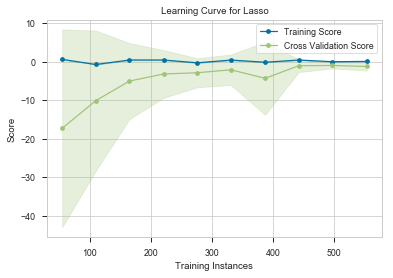

In [126]:
viz = LearningCurve(grid3.best_estimator_, n_jobs=-1,cv=10, scoring='r2',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X, y)
#plt.ylim(-3,-0.5)
viz.poof()

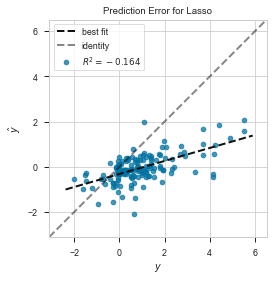

In [127]:
perror = PredictionError(grid3.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

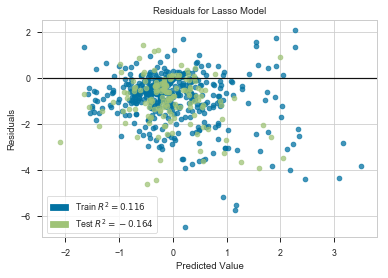

In [128]:
visualizer = ResidualsPlot(grid3.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


# ElasticNet

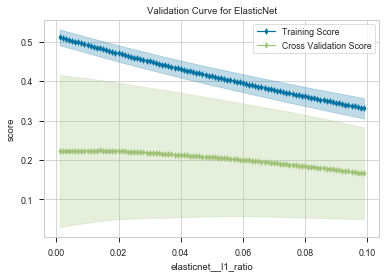

In [138]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()
#scaler = MinMaxScaler()
scaler = StandardScaler()
#2)
lr_model = ElasticNet(random_state=1212)
#3) Crear pipeline
pipeline4 = make_pipeline(selector,scaler,lr_model)

# Extract the instances and target
viz = ValidationCurve(
    pipeline4, njobs=-1,param_name="elasticnet__l1_ratio",
    param_range=np.arange(0.001,0.1,0.001), cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [429]:
#1)
selector = VarianceThreshold()
#scaler = MinMaxScaler()
scaler = StandardScaler()
#2)
lr_model = ElasticNet(random_state=1212)
#3) Crear pipeline
pipeline4 = make_pipeline(selector,scaler,lr_model)


# fit
pipeline4.fit(X_train,y_train)

# 5) hiperparametros a ajustar
param_grid = {"elasticnet__alpha":[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8],'elasticnet__l1_ratio':[0.035],"elasticnet__normalize":[True,False],"elasticnet__fit_intercept":[True,False]}

grid4 = GridSearchCV(pipeline4, param_grid, verbose=5, n_jobs=-1,cv=10,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid4.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 329 out of 360 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    1.6s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1212, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'elasticnet__alpha': [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8], 'elasticnet__l1_ratio': [0.035], 'elasticnet__normalize': [True, False], 'elasticnet__fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [430]:
# index of best scores
rmse_bestCV_test_index = grid4.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid4.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid4.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid4.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid4.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid4.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid4.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid4.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid4.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid4.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid4.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid4.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(grid4.best_params_)
y_test_pred = grid4.best_estimator_.predict(X_test)
y_train_pred = grid4.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))

CV test RMSE 1.254779 +/- 0.666058
CV train RMSE 1.105991 +/- 0.169110
CV test r2 0.215656 +/- 0.161986
CV train r2 0.440756 +/- 0.021373
{'elasticnet__alpha': 1, 'elasticnet__fit_intercept': True, 'elasticnet__l1_ratio': 0.035, 'elasticnet__normalize': False}

RMSE for test dataset: 1.07
RMSE for train dataset: 1.12
pearson corr  0.622072


In [439]:
grid4.best_estimator_.named_steps['variancethreshold']

VarianceThreshold(threshold=0.0)

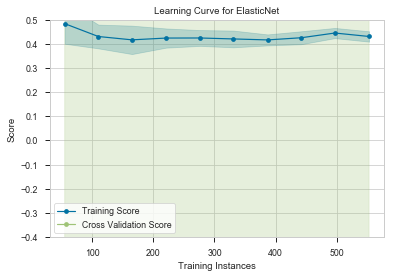

In [431]:
viz = LearningCurve(grid4.best_estimator_, n_jobs=-1,cv=10, scoring='r2',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X, y)
plt.ylim(-0.4,0.5)
viz.poof()

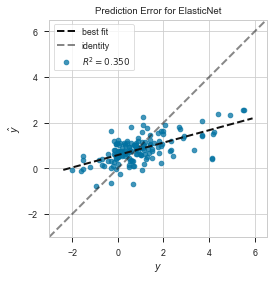

In [186]:
perror = PredictionError(grid4.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

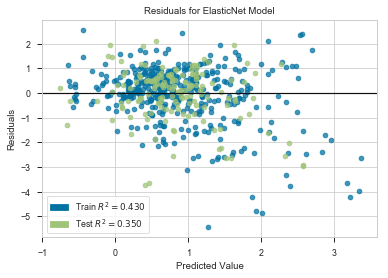

In [187]:
visualizer = ResidualsPlot(grid4.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


## Testing transformedtargetregressor

In [ ]:
'elasticnet__alpha': 0.025, 'elasticnet__fit_intercept': False, 'elasticnet__l1_ratio': 0.04, 'elasticnet__normalize': True}


In [160]:
PowerTransformer?

In [117]:
#1)
scaler = StandardScaler()
#scaler = MinMaxScaler()

#2)
#pca = PCA()

lr_model = ElasticNet(alpha=0.009,fit_intercept=False,l1_ratio=1,normalize=True)
#3) Crear pipeline
#pipeline3 = make_pipeline(scaler, pca,lr_model)
pipeline5 = make_pipeline(scaler,lr_model)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline5, transformer=PowerTransformer())

regr_trans.fit(X_train,y_train)

TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=0.009, copy_X=True, fit_intercept=False, l1_ratio=1,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True))

In [118]:
y_test_pred = regr_trans.predict(X_test)
y_train_pred = regr_trans.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print("r2 test score {}".format(regr_trans.score(X_test,y_test)))
print("r2 train score {}".format(regr_trans.score(X_train,y_train)))


RMSE for test dataset: 1.13
RMSE for train dataset: 1.12
pearson corr  0.570388
r2 test score 0.28345176759268287
r2 train score 0.4233097005295079


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

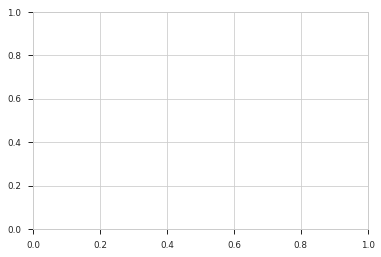

In [163]:
viz = LearningCurve(regr_trans, n_jobs=-1,cv=10, scoring='r2',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X, y)
#plt.ylim(-10,0)
viz.poof()

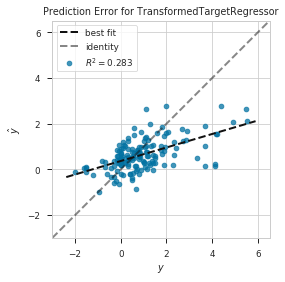

In [119]:
perror = PredictionError(regr_trans)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

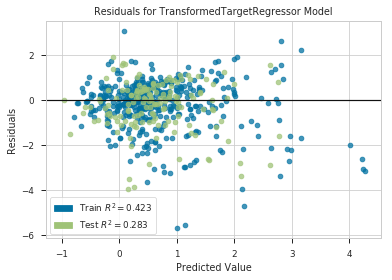

In [120]:
visualizer = ResidualsPlot(regr_trans,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

# Apply SMOTE, only on train data, and test only one
https://stackoverflow.com/questions/48370150/how-to-implement-smote-in-cross-validation-and-gridsearchcv

In [378]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] <= -0.4) | (df_final['ddG_exp'] >= 2.4),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG_exp'] <= -0.2),1,0)


In [379]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 475
Before OverSampling, counts of label '0': 140


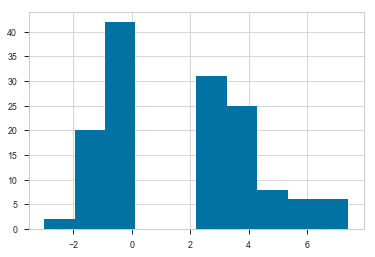

In [380]:
df_final.loc[df_final['class'] == 0]['ddG_exp'].hist()

In [381]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.75,random_state=1313)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [397]:
smote = ovs.SMOTE(random_state=1212,m_neighbors=10)
#smote = ovs.BorderlineSMOTE(random_state=1212,m_neighbors=10,kind='borderline-2')
#adasyn = ovs.ADASYN(random_state=1212,n_neighbors=10)
#X_train_re , y_train_re = adasyn.fit_sample(X_train,y_train)
X_train_re , y_train_re = smote.fit_sample(X_train,y_train)

In [398]:
# back to originalk shape and target
X_train_normal = X_train_re[:,:-1]
y_train_normal = X_train_re[:,-1]

X_test_normal = X_test.iloc[:,:-1]
y_test_normal = X_test.iloc[:,-1]


In [403]:
model = grid2.best_estimator_.fit(X_train_normal,y_train_normal)
#print('CV test RMSE',np.sqrt(-grid.best_score_))
#print('CV train RMSE',np.sqrt(-grid.cv_results_['mean_train_score'].max()))

y_test_pred = model.predict(X_test_normal.values)
y_train_pred = model.predict(X_train_normal)

print('Training score (r2): {}'.format(r2_score(y_train_normal, y_train_pred)))
print('Test score (r2): {}'.format(r2_score(y_test_normal.values, y_test_pred)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test_normal.values, y_test_pred)), 2)))
print("Root mean square error for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train_normal, y_train_pred)), 2)))
print("pearson corr: ",np.corrcoef(y_test_pred,y_test_normal.values)[0][1])

Training score (r2): 0.62032101946811
Test score (r2): 0.2755923455159801

Root mean square error for test dataset: 1.39
Root mean square error for train dataset: 1.12
pearson corr:  0.5306837123246114


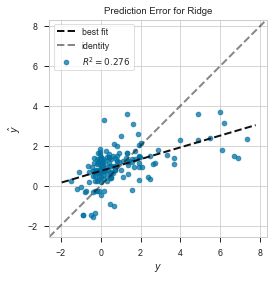

In [404]:
perror = PredictionError(model)

perror.fit(X_train_normal, y_train_normal)  # Fit the training data to the visualizer
perror.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
g = perror.poof()

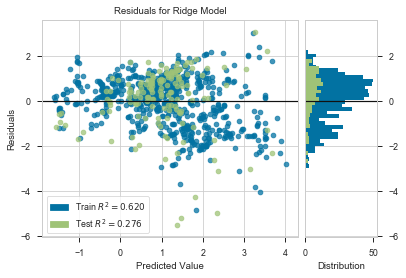

In [405]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_normal, y_train_normal)  # Fit the training data to the model
visualizer.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data


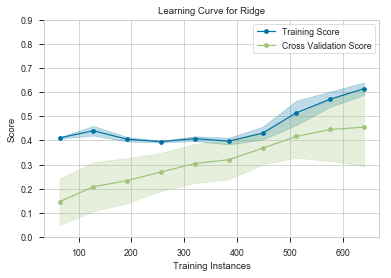

In [406]:
viz = LearningCurve(model, n_jobs=-1,cv=10, scoring='r2',train_sizes=np.linspace(.1, 1.0, 10))
viz.fit(X_train_normal, y_train_normal)
plt.ylim(0,0.9)
viz.poof()

# SMOTE , ADASYN , Kfold manually

In [49]:
from sklearn.compose import TransformedTargetRegressor
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold


In [141]:
df_final = df_final.astype(float,copy=True)

In [142]:
# forma 1
#df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < -0.4) | (df_final['ddG(kcal/mol)'] > 2.4),0,1)
# forma 2 
df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < 0),1,0)

print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 140
Before OverSampling, counts of label '0': 475


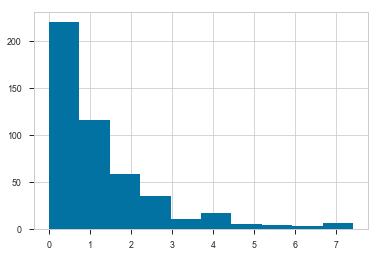

In [145]:
df_final.loc[df_final['class'] == 0]['ddG(kcal/mol)'].hist()

In [146]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.7,random_state=12)


/home/Vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [244]:
cv_splits = 10

cv_test_mse = np.zeros(cv_splits)
cv_test_r2 = np.zeros(cv_splits)
cv_train_mse = np.zeros(cv_splits)
cv_train_r2 = np.zeros(cv_splits)

#kf = KFold(n_splits=cv_splits,random_state=12)
kf = StratifiedKFold(n_splits=cv_splits,random_state=12)
for i,(train_index, validation_index) in enumerate(kf.split(X_train,y_train)):
    
    X_train_cv, X_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train.values[train_index], y_train.values[validation_index]
    
    # Oversampling
    #smote = ovs.SMOTE(random_state=12,m_neighbors=10)
    #smote = ovs.BorderlineSMOTE(random_state=12,m_neighbors=40,kind='borderline-2')
    adasyn = ovs.ADASYN(random_state=12,n_neighbors=40)
    X_train_ovs , y_train_ovs = adasyn.fit_sample(X_train_cv,y_train_cv)
    #X_train_ovs , y_train_ovs = smote.fit_sample(X_train_cv,y_train_cv)
    
    # Back to normal dataset
    X_train_normal = X_train_ovs[:,:-1]
    y_train_normal = X_train_ovs[:,-1]
    
    X_validation_normal = X_validation_cv[:,:-1]
    y_validation_normal = X_validation_cv[:,-1]
    
    # Standarization
    scaler = StandardScaler().fit(X_train_normal)
    #scaler = RobustScaler().fit(X_train_normal)
    X_train_normal_std = scaler.transform(X_train_normal)
    X_validation_normal_std = scaler.transform(X_validation_normal)
    
    # PCA
    #pca = PCA(n_components=40,random_state=12)
    #pca.fit(X_train_normal_std)
    
    # Model
    model = Ridge(alpha=7.5,fit_intercept=True,normalize=True)
    model.fit(X_train_normal_std,y_train_normal)
    
    # Test
    y_test_pred = model.predict(X_validation_normal_std)
    y_train_pred = model.predict(X_train_normal_std)
    
    # Scoring
    
    test_mse = mean_squared_error(y_validation_normal,y_test_pred)
    test_r2 = r2_score(y_validation_normal,y_test_pred)
    cv_test_mse[i] = test_mse
    cv_test_r2[i] = test_r2
    
    train_mse = mean_squared_error(y_train_normal,y_train_pred)
    train_r2 = r2_score(y_train_normal,y_train_pred)
    cv_train_mse[i] = train_mse
    cv_train_r2[i] = train_r2
    
print("Test scores")
print("RMSE",np.sqrt(cv_test_mse.mean()))
print("r2",cv_test_r2.mean())

print("Train scores")
print("RMSE",np.sqrt(cv_train_mse.mean()))
print("r2",cv_train_r2.mean())


Test scores
RMSE 1.3439106463488741
r2 0.19969179332476325
Train scores
RMSE 1.075063495416584
r2 0.4140538034306169


In [220]:
np.sqrt(cv_test_mse)

array([1.0209668 , 1.33408245, 1.48869659, 0.85747869, 1.49938676,
       0.87571434, 0.86311325, 1.45220773, 1.28949294, 2.05810153])